# Importing Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import math
from osgeo import gdal,gdal_array
from sklearn.decomposition import PCA

In [2]:
# Importing Product and getting data from the band
pr_d = gdal.Open('Dataset_963A/LandMasked_Amplitude_VV.tif')
product = gdal_array.LoadFile('Dataset_963A/LandMasked_Amplitude_VV.tif')
product

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [3]:
def save_img2Geotiff(img,filename):
    driver = gdal.GetDriverByName("GTiff")
    outdata = driver.Create(filename, rows, col, 1, gdal.GDT_Float32)
    outdata.SetGeoTransform(pr_d.GetGeoTransform())##sets same geotransform as input
    outdata.SetProjection(pr_d.GetProjection())##sets same projection as input
    outdata.GetRasterBand(1).WriteArray(img)

In [4]:
#Computing rows and columns
band_data_arr = np.array(product)
rows,col = band_data_arr.shape

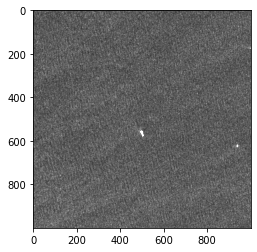

In [36]:
#Comuting subset of the image for demo processing
subset_min_size = 5000
subset_max_size = 6000
size = subset_max_size - subset_min_size
subset_data = band_data_arr[subset_min_size:subset_max_size,subset_min_size:subset_max_size]
subset_data = np.array(subset_data)
plt.imshow(subset_data,cmap='gray',vmin=0,vmax=255)
plt.imsave('Input_Image.tiff',subset_data,cmap='gray')
#print(subset_data.shape)

In [37]:
components = 8
s_pca = PCA(n_components=components)
for_s_pca = s_pca.fit_transform(subset_data)
#plt.imshow(for_s_pca,cmap='gray')
#Image.fromarray(for_s_pca).show()

In [38]:
max_v = for_s_pca[:,0]
min_v = for_s_pca[:,(components-1)]
threshold = (max_v.std() + min_v.std())/2
print(threshold)

180.5178680419922


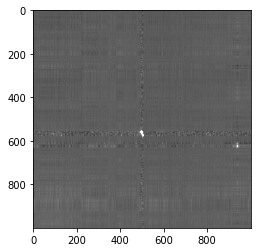

In [39]:
inv_s_pca = s_pca.inverse_transform(for_s_pca)
plt.imshow(inv_s_pca,cmap='gray',vmin=0,vmax=255)
plt.imsave('PrincipalComponentImage.tiff',inv_s_pca,cmap='gray')

In [40]:
temp = inv_s_pca.reshape(size**2,1)

In [41]:
for d in range(len(temp)):
    if temp[d] < threshold:
        temp[d] = 0
    else:
        temp[d] = 1

In [42]:
fin_img = temp.reshape(int(math.sqrt(len(temp))),int(math.sqrt(len(temp))))

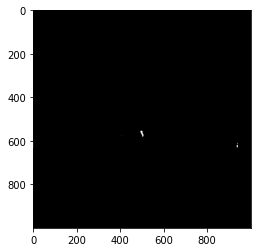

In [43]:
plt.imshow(fin_img,cmap='gray')
plt.imsave('Output_fromPCA.tiff',fin_img,cmap='gray')